# Taxi Demand Prediction - Support Vector Machine
---
In this notebook, we build a model for predicting taxi demand in Chicago. The model is based on the information provided by the city of Chicago in 2015.

Furthermore, the model is based on all of the available data. Since the prediction target is taxi demand which is calculated by data aggregation, we won't encounter any memory problems.

To build our demand prediction model, we proceed as following:

In [1]:
cd ..

/Users/simonwolf/git/aaa21


In [2]:
import utils, feature_engineering, geo_engineering, preprocessing, prediction_utils, prediction_svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
%matplotlib inline
pd.options.mode.chained_assignment = None

# Daily Models
---
Explanations...

## Data Preparation
---

In [3]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet',
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

daily_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D')
#daily_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
#                                            use_hexes=True,hex_resolution=7)
#daily_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
#                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Feature Engineering
---
In this section we add the following spatial and temporal features to our data before prediction.
- Distance to Chicago City Center
- Distance to Chicago Airport
- Holiday Events

In [4]:
#Spatial Features
daily_demand = feature_engineering.add_spatial_features(daily_demand)
#daily_demand_hex_7 = feature_engineering.add_spatial_features(daily_demand_hex_7,with_hex=7,hex_res=7)
#daily_demand_hex_6 = feature_engineering.add_spatial_features(daily_demand_hex_6,with_hex=6,hex_res=6)
#Holidays
daily_demand = feature_engineering.add_holidays(daily_demand)
#daily_demand_hex_6 = feature_engineering.add_holidays(daily_demand_hex_6)
#daily_demand_hex_7 = feature_engineering.add_holidays(daily_demand_hex_7)

### Daily Model - Community Areas
---
In this section we build our nn model for demand prediction using community areas as our geographical attributes. we build different models and opt for the final model by comparing the overall evaluation metrics.

### Model Architecture
---
To gain a better understanding of our data and the amount of complexity needed in the nn architecture we first start our daily model by a simple 50 * 25 structure. After observing the behavoiur of the model we adjust the layer structure. First by adding/removing nodes , Second by increasing/decreasing the number of hidden layers of the network. For the sake of brevity this notebook does not show all tested nn architectures.

_Note: This was an iterative process. We didn't use brut force algorithms to search for the optimal structure on a grid as it is not computationaly feasible._

### Suitable Metrics
---
To gain a better understanding which metrics we should apply to our problem we plot the prediction target to identify the distribution type.

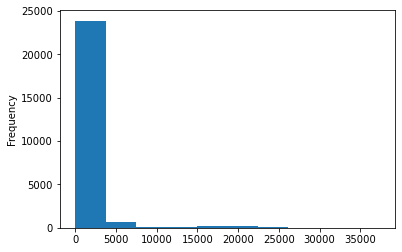

In [5]:
daily_demand['Demand (D)'].plot.hist()
plt.show()

As we expected the target is extremely skewed. Which would make the prediction metrics non telling. To tackle this obstacle, we transform the target logarithmically. And use the mean squared logarithmic error as our metric.

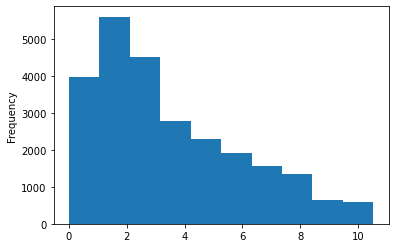

In [6]:
daily_demand['Demand (D)'] = np.log(daily_demand['Demand (D)'])
daily_demand['Demand (D)'].plot.hist()
plt.show()

In [7]:
daily_demand, target, cont_vars, cat_vars = (prediction_utils.
                                             preprocess_data_for_prediction(daily_demand, 
                                                                            temporal_resolution='D'))

In [8]:
#Preprocessed data
daily_demand.head(5)

,Pickup Community Area,Demand (D),Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Holiday,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,6.006353,100.0,1034.250777,-5.435774,249.09522,9.069681,14.731612,9653.373658,True,...,1,3,1,False,True,False,True,False,True,1420070400
1,10,3.465736,100.0,1034.250777,-5.435774,249.09522,9.069681,18.830572,9653.213140,True,...,1,3,1,False,True,False,True,False,True,1420070400
2,11,4.290459,100.0,1034.250777,-5.435774,249.09522,9.069681,16.315833,9653.268017,True,...,1,3,1,False,True,False,True,False,True,1420070400
3,12,2.708050,100.0,1034.250777,-5.435774,249.09522,9.069681,16.744923,9653.266876,True,...,1,3,1,False,True,False,True,False,True,1420070400
4,13,3.663562,100.0,1034.250777,-5.435774,249.09522,9.069681,14.040299,9653.330387,True,...,1,3,1,False,True,False,True,False,True,1420070400


In [9]:
#Train - Test Split
daily_demand_train, daily_demand_test = prediction_svm.split_data_sets_for_svm(daily_demand, test_size=0.2)

In [10]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(cont_vars)
print('\nCategorical variables:')
print(cat_vars)

Continuous variables:
['Humidity(%)', 'Pressure(hPa)', 'Temperature(C)', 'Wind Direction(Meteoro. Degree)', 'Wind Speed(M/S)', 'City Center Distance', 'Airport Distance', 'Elapsed']

Categorical variables:
['Pickup Community Area', 'Holiday', 'Year', 'Month', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Dayofyear', 'Week']


#### SVM Model With Linear Kernel
---

In [11]:
# Target Extraction
daily_demand_train_target = daily_demand_train.pop(target)
daily_demand_test_target = daily_demand_test[target]
X_test = daily_demand_test.drop(columns=[target])

In [12]:
svr_linear = SVR(kernel='linear')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_linear)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [13]:
# Training SVM Linear Kernel
svr_linear_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [14]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  45.838 %
sMAPE:  34.270 %
MAE:  208.861
MSE:  819865.833
RMSE:  905.464
R2:  90.508 %
Max Residual Error:  16213.439


#### SVM Model With Polynomial Kernel
---

In [15]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [16]:
# Training SVM Polynomial Degree 2 Kernel
svr_poly_2_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [17]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  45.630 %
sMAPE:  33.216 %
MAE:  188.442
MSE:  684351.091
RMSE:  827.255
R2:  92.077 %
Max Residual Error:  13199.804


In [18]:
# Checking degree 3
svr_poly_3 = SVR(kernel='poly', degree=3)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_3)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [19]:
# Training SVM Polynomial Degree 3 Kernel
svr_poly_3_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [20]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  50.439 %
sMAPE:  35.670 %
MAE:  213.529
MSE:  906322.564
RMSE:  952.010
R2:  89.507 %
Max Residual Error:  16541.819


#### SVM Model With RBF Kernel
---

In [21]:
svr_rbf = SVR(kernel='rbf')

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_rbf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [22]:
# Training SVM RBF Kernel
svr_rbf_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [23]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  68.662 %
sMAPE:  43.156 %
MAE:  259.653
MSE:  1528861.184
RMSE:  1236.471
R2:  82.299 %
Max Residual Error:  18220.975


Overfit to training data -> tune hyperparameter!

#### Tuning hyperparameter
---

In [24]:
svr_poly_2 = SVR(kernel='poly', degree=2)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_poly_2)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [25]:
# Define Model Parameters for First Grid Search [0.5, 4, 32, 256]
model_params = {
                'svr model__C':[2**j for j in range(-1,10,3)], 
                'svr model__epsilon':[2**j for j in range(-1,10,3)],
                'svr model__coef0':[2**j for j in range(-1,10,3)],
                'svr model__gamma':[2**j for j in range(-1,10,3)]
                }

In [26]:
# First Grid Search
prediction_svm.find_best_parameters_for_model(pipeline, 
                                              daily_demand_train, 
                                              daily_demand_train_target, 
                                              model_params, 
                                              scoring='neg_mean_absolute_error',
                                              verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best neg_mean_absolute_error Score was: -0.377129530428002
The best hyper parameters for the model are:
{'svr model__C': 0.5, 'svr model__coef0': 256, 'svr model__epsilon': 0.5, 'svr model__gamma': 0.5}


In [49]:
# Define Model Parameters for Second Grid Search (TODO)
model_params = {
                'svr model__C':[2**j for j in range(-1,10,3)], 
                'svr model__epsilon':[2**j for j in range(-1,10,3)],
                'svr model__coef0':[2**j for j in range(-1,10,3)],
                'svr model__gamma':[2**j for j in range(-1,10,3)]
                }

In [50]:
# Second Grid Search
prediction_svm.find_best_parameters_for_model(pipeline, 
                                              daily_demand_train, 
                                              daily_demand_train_target, 
                                              model_params, 
                                              scoring='neg_mean_absolute_error',
                                              verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 343 candidates, totalling 1715 fits


KeyboardInterrupt: 

In [27]:
# Train Model with fitted hyperparameters
svr_tuned = SVR(kernel='poly', degree=2, C=0.5, gamma=0.5, epsilon=0.5, coef0=256)

pipeline = prediction_svm.make_pipeline_for_svm(cat_vars, cont_vars, svr_tuned)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity(%)',
                                                   'Pressure(hPa)',
                                                   'Temperature(C)',
                                                   'Wind Direction(Meteoro. '
                                                   'Degree)',
                                                   'Wind Speed(M/S)',
                                                   'City Center Distance',
                                                   'Airport Distance',
                                                   'Elapsed']),
                                                 ('one hot encoder',
                               

In [28]:
svr_tuned_fitted = pipeline.fit(daily_demand_train, daily_demand_train_target)

In [29]:
# Model Scores
y_pred = pipeline.predict(X_test)

prediction_utils.get_prediction_scores(y_true=np.exp(daily_demand_test_target), 
                                       y_predicted=np.exp(y_pred), 
                                       s_mape=True,
                                       prediction_type='svr')

-------MODEL SCORES-------
MAPE:  43.844 %
sMAPE:  35.071 %
MAE:  197.255
MSE:  602595.634
RMSE:  776.270
R2:  93.023 %
Max Residual Error:  13669.722


#### Adding Demand to visualize Prediction in the end
---

In [ ]:
daily_demand_test['Demand (D)'] = np.exp(daily_demand_test['Demand (D)']).astype(int)
daily_demand_test['Demand (D) Prediction'] = np.exp(y_pred).astype(int)
daily_demand_test

### Daily Model - Hex 7
---

In [11]:
#Log transformation
daily_demand_hex_7['Demand (D)'] = np.log(daily_demand_hex_7['Demand (D)'])

In [12]:
#Train - Validation - Test Split
train_data, val_data, test_data = prediction_svm.split_data_sets_for_svm(daily_demand_hex_7, 
                                                                         temporal_resolution='D',
                                                                         test_size=0.2, 
                                                                         validation_size=0.2)

In [13]:
#Augmented data
train_data.head(5)

,Demand (D),Holiday_True,Holiday_False,Year_2015.0,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,Month_6.0,...,hex_7_pickup_6.08661347831382e+17,hex_7_pickup_6.086613320104673e+17,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Elapsed
0,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,1.48221,0.603976,-1.075427,0.827983,3.181182,2.659386,2.396822,-1.717593
1,0.693147,1,0,1,1,0,0,0,0,0,...,0,0,1.48221,0.603976,-1.075427,0.827983,3.181182,1.828555,1.870248,-1.717593
2,6.493754,1,0,1,1,0,0,0,0,0,...,0,0,1.48221,0.603976,-1.075427,0.827983,3.181182,0.790359,-0.357017,-1.717593
3,1.098612,1,0,1,1,0,0,0,0,0,...,0,0,1.48221,0.603976,-1.075427,0.827983,3.181182,0.762346,-0.093047,-1.717593
4,0.000000,1,0,1,1,0,0,0,0,0,...,0,0,1.48221,0.603976,-1.075427,0.827983,3.181182,0.808911,0.170834,-1.717593


In [14]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_data.select_dtypes(include="number").columns.values)
print('\nCategorical variables:')
print(train_data.select_dtypes(include="category").columns.values)

Continuous variables:
['Demand (D)' 'Humidity(%)' 'Pressure(hPa)' 'Temperature(C)'
 'Wind Direction(Meteoro. Degree)' 'Wind Speed(M/S)'
 'City Center Distance' 'Airport Distance' 'Elapsed']

Categorical variables:
['Holiday_True' 'Holiday_False' 'Year_2015.0' 'Month_1.0' 'Month_2.0'
 'Month_3.0' 'Month_4.0' 'Month_5.0' 'Month_6.0' 'Month_7.0' 'Month_8.0'
 'Month_9.0' 'Month_10.0' 'Month_11.0' 'Month_12.0' 'Day_1.0' 'Day_2.0'
 'Day_3.0' 'Day_4.0' 'Day_5.0' 'Day_6.0' 'Day_7.0' 'Day_8.0' 'Day_9.0'
 'Day_10.0' 'Day_11.0' 'Day_12.0' 'Day_13.0' 'Day_14.0' 'Day_15.0'
 'Day_16.0' 'Day_17.0' 'Day_18.0' 'Day_19.0' 'Day_20.0' 'Day_21.0'
 'Day_22.0' 'Day_23.0' 'Day_24.0' 'Day_25.0' 'Day_26.0' 'Day_27.0'
 'Day_28.0' 'Day_29.0' 'Day_30.0' 'Day_31.0' 'Dayofweek_3.0'
 'Dayofweek_4.0' 'Dayofweek_5.0' 'Dayofweek_6.0' 'Dayofweek_0.0'
 'Dayofweek_1.0' 'Dayofweek_2.0' 'Is_month_end_False' 'Is_month_end_True'
 'Is_month_start_True' 'Is_month_start_False' 'Is_quarter_end_False'
 'Is_quarter_end_True' 'Is_qua

In [15]:
prediction_svm.prediction_svm(train_data=train_data, test_data=test_data, target='Demand (D)', s_mape=False)

-------MODEL SCORES-------
MAPE:  755.225 %
MAE:  464.766
MSE:  2548741.056
RMSE:  1596.478
R2:  70.031 %
Max Residual Error:  16240.426


### Daily Model - Hex 6
---

In [16]:
#Log transformation
daily_demand_hex_6['Demand (D)'] = np.log(daily_demand_hex_6['Demand (D)'])

In [17]:
#Train - Validation - Test Split
train_data, val_data, test_data = prediction_svm.split_data_sets_for_svm(daily_demand_hex_6, 
                                                                         temporal_resolution='D',
                                                                         test_size=0.2, 
                                                                         validation_size=0.2)

In [18]:
#Augmented data
train_data.head(5)

,Demand (D),hex_6_pickup_6.04157731930112e+17,hex_6_pickup_6.04157747230933e+17,hex_6_pickup_6.041577473651507e+17,hex_6_pickup_6.041577483046748e+17,hex_6_pickup_6.041577770272686e+17,hex_6_pickup_6.041577771614863e+17,hex_6_pickup_6.041577789063168e+17,hex_6_pickup_6.041577790405345e+17,hex_6_pickup_6.041577794431877e+17,...,Week_52.0,Week_53.0,Humidity(%),Pressure(hPa),Temperature(C),Wind Direction(Meteoro. Degree),Wind Speed(M/S),City Center Distance,Airport Distance,Elapsed
0,1.098612,0,0,0,0,0,0,0,0,0,...,0,0,1.482011,0.610523,-1.082441,0.832682,3.185224,2.043638,1.970379,-1.721428
1,1.098612,0,0,0,0,0,0,0,0,0,...,0,0,1.482011,0.610523,-1.082441,0.832682,3.185224,2.043638,1.970379,-1.721428
2,6.498282,0,0,0,0,0,0,0,0,0,...,0,0,1.482011,0.610523,-1.082441,0.832682,3.185224,0.670123,-0.390189,-1.721428
3,6.498282,0,0,0,0,0,0,0,0,0,...,0,0,1.482011,0.610523,-1.082441,0.832682,3.185224,0.670123,-0.390189,-1.721428
4,1.386294,0,0,0,0,0,0,0,0,0,...,0,0,1.482011,0.610523,-1.082441,0.832682,3.185224,1.103893,0.179528,-1.721428


In [19]:
#Categorical and Continuous Variables
print('Continuous variables:')
print(train_data.select_dtypes(include="number").columns.values)
print('\nCategorical variables:')
print(train_data.select_dtypes(include="category").columns.values)

Continuous variables:
['Demand (D)' 'Humidity(%)' 'Pressure(hPa)' 'Temperature(C)'
 'Wind Direction(Meteoro. Degree)' 'Wind Speed(M/S)'
 'City Center Distance' 'Airport Distance' 'Elapsed']

Categorical variables:
['hex_6_pickup_6.04157731930112e+17' 'hex_6_pickup_6.04157747230933e+17'
 'hex_6_pickup_6.041577473651507e+17' 'hex_6_pickup_6.041577483046748e+17'
 'hex_6_pickup_6.041577770272686e+17' 'hex_6_pickup_6.041577771614863e+17'
 'hex_6_pickup_6.041577789063168e+17' 'hex_6_pickup_6.041577790405345e+17'
 'hex_6_pickup_6.041577794431877e+17' 'hex_6_pickup_6.041577795774054e+17'
 'hex_6_pickup_6.041577797116232e+17' 'hex_6_pickup_6.041577799800586e+17'
 'hex_6_pickup_6.041577801142764e+17' 'hex_6_pickup_6.041577802484941e+17'
 'hex_6_pickup_6.041577803827118e+17' 'hex_6_pickup_6.041577805169295e+17'
 'hex_6_pickup_6.041577806511473e+17' 'hex_6_pickup_6.04157780785365e+17'
 'hex_6_pickup_6.041577833355018e+17' 'hex_6_pickup_6.041577836039373e+17'
 'hex_6_pickup_6.041745755838874e+17' '

 'Week_49.0' 'Week_50.0' 'Week_51.0' 'Week_52.0' 'Week_53.0']


In [20]:
prediction_svm.prediction_svm(train_data=train_data, test_data=test_data, target='Demand (D)', s_mape=False)

-------MODEL SCORES-------
MAPE:  411.477 %
MAE:  1291.614
MSE:  19167376.972
RMSE:  4378.056
R2:  59.285 %
Max Residual Error:  32184.236


In [21]:
#Memory Cleaning
del daily_demand
del daily_demand_hex_6
del daily_demand_hex_7